# A Gaussian toolbox

### Gaussian manipulations made simple

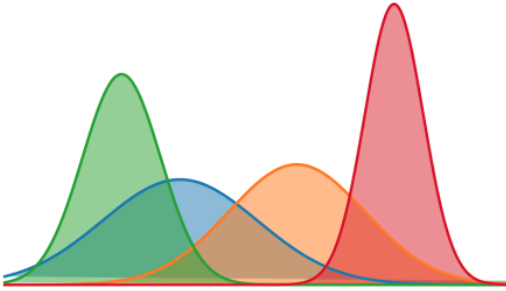

# Outline

### 1. Python toolbox for _Gaussian algebra_

<img src="images/gauss.jpeg" width="400" height="100">


### 2. Simple applications

<img src="images/regression.png" width="400" height="100">

### 3. Time-series models

<img src="images/timeseries.png" width="300" height="100">

# 1. Python toolbox for _Gaussian algebra_

<center>
<img src="images/gauss.jpeg" width="800" height="200">
</center>

# Why are Gaussians so nice?

### Analytical tractability

+ Normalization
+ Conditioning
+ Marginalization
+ Integration
+ Conjugacy

### Applications

+ Bayesian Linear Regression
+ Timeseries models: Kalman filter
+ Gaussian process
+ etc...

# Motivation

While the math is quite simple, and you basically do the same operations over and over, derivations can become quite cumbersome.

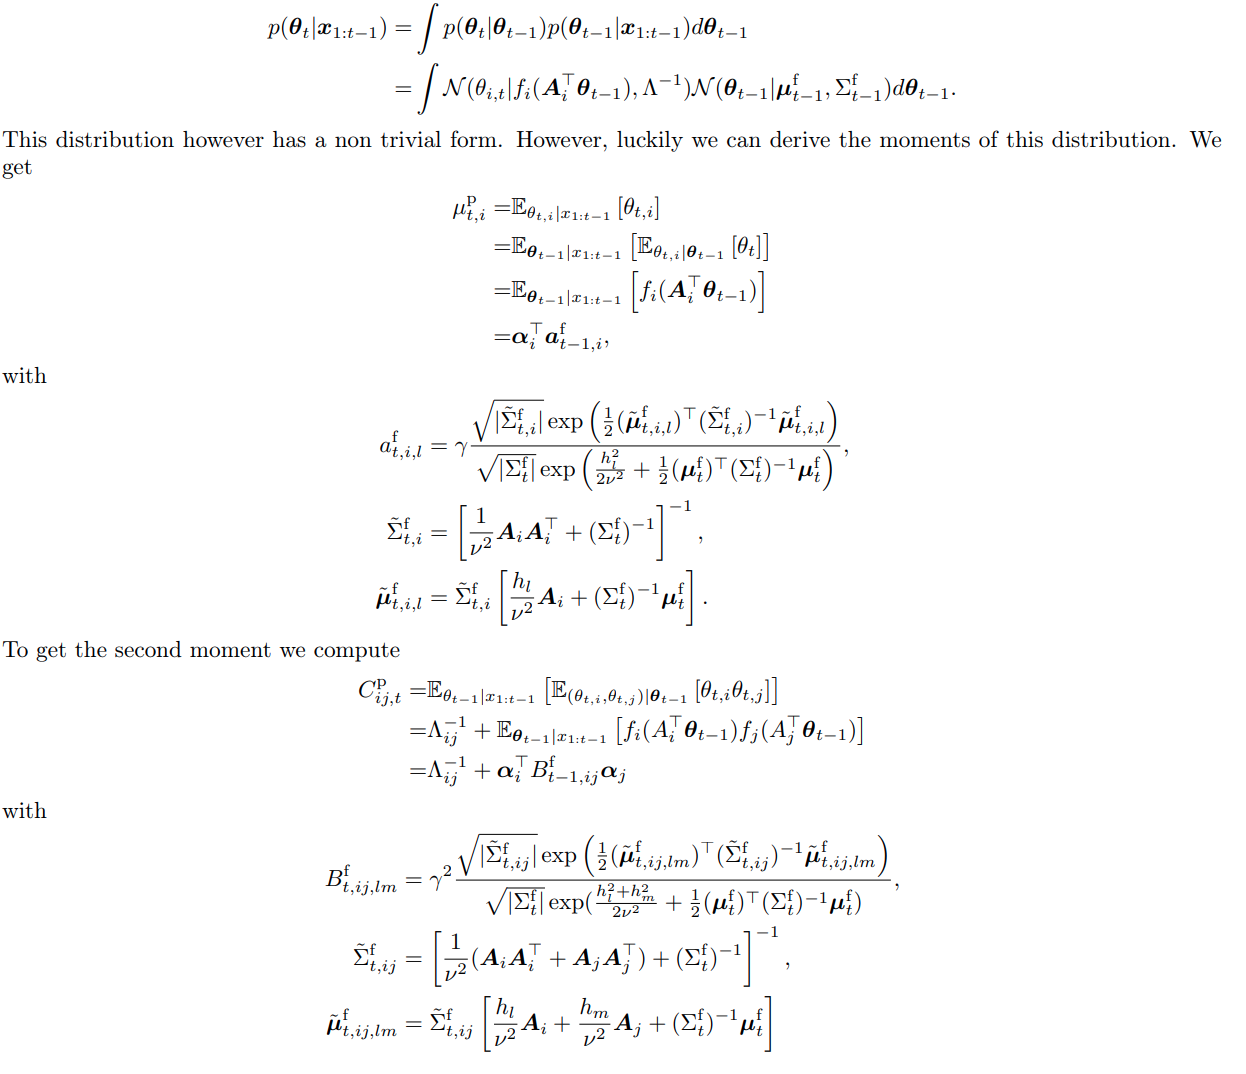

__Idea__: Provide a toolbox, which provides these basic operations, and keeps track of certain things automatically.

### What's already there?

<center>
(low-level) numpy < scipy < tensorflow/pytorch/jax < pyro/tfp/pyMC3 < scikit-learn (high level)

<table>
  <tr>
    <td>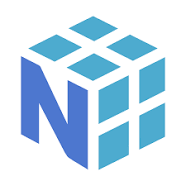</td>
    <td>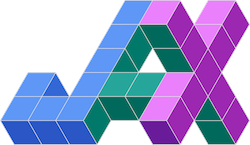 </td>
    <td>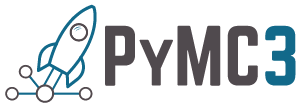 </td>
    <td>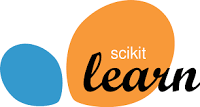 </td>
  </tr>
</table>
</center>

$\newcommand{\bx}{\mathbf{x}}$
$\newcommand{\bX}{\mathbf{X}}$
$\newcommand{\bmu}{\boldsymbol{\mu}}$
$\newcommand{\bnu}{\boldsymbol{\nu}}$
$\newcommand{\by}{\mathbf{y}}$
$\newcommand{\bY}{\mathbf{Y}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\EE}{\mathbb{E}}$
$\newcommand{\diff}{\mathrm{d}}$

# The Gaussian hierarchy


### ```Gaussian density``` $\subset$ ```Gaussian Measure``` $\subset$ ```Gaussian conjugate factor```

## 1. Gaussian Conjugate Factor:

$$
u(\bX) = \exp\left(-\frac{1}{2}\bX^\top\Lambda \bX + \bX^\top\bnu + \ln \beta\right)
$$

#### Nomenclature:
+ $\Lambda\in \RR^{d\times d}$ p.s.d. matrix
+ $\bnu\in \RR^d$
+ $\ln\beta\in \RR$

#### Properties

+ Conjugacy:
$$
u_{12}(\bX) = u_{1}(\bX)u_{2}(\bX) 
$$

In [ ]:
from jax import numpy as jnp
from matplotlib import pyplot as plt
import objax
from IPython.display import clear_output
import time
from tqdm import tqdm

In [ ]:
from gaussian_toolbox.gaussian_algebra import factors

# Create plot grid
reso = 70
xrange = jnp.linspace(-5,5,reso)
xmesh, ymesh = jnp.meshgrid(xrange, xrange)
x = jnp.vstack([xmesh.flatten(), ymesh.flatten()]).T

# Define terms for factor
Lambda_u = jnp.array([[[5,0],
                       [0,0]]])
nu_u = jnp.array([[0,0]])
ln_beta_u = jnp.array([0,])

# Create factor u(x)
u_X = factors.ConjugateFactor(Lambda=Lambda_u, nu=nu_u, ln_beta=ln_beta_u)
print(u_X)

In [ ]:
u_x = u_X(x)

# Plotting
plt.figure(figsize=(6,5))
plt.pcolor(xrange, xrange, u_x.reshape((reso,reso)), shading='nearest')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.colorbar(label='$u(\mathbf{x})$')
plt.show()

## 2. Gaussian Measure:

Inherits from ```ConjugateFactor```!

$$
\phi(\bX) = \exp\left(-\frac{1}{2}\bX^\top\Lambda \bX + \bX^\top\bnu + \ln \beta\right)
$$

#### Nomenclature:
+ __$\Lambda\in \RR^{d\times d}$ p.d. matrix__
+ $\bnu\in \RR^d$
+ $\ln\beta\in \RR$

#### Properties

+ Properties of the conjugate factor
+ Conjugacy:
$$
\tilde{\phi}(\bX) = u(\bX)\phi(\bX) 
$$
+ Integrable:
$$
0<\int \diff \phi(\bX) < \infty
$$
+ Analytical solutions
$$
\int f(\bX)\diff \phi(\bX)
$$
where $f$ can be 
 + Conjugate Gaussian Factors
 + polynomials $(A\bX + \mathbf{a})^\top(B\bX + \mathbf{b})...$ (see [Isserlis' theorem](https://en.wikipedia.org/wiki/Isserlis%27_theorem))
 + and also other functions (see [list of Gaussian integrals](https://en.wikipedia.org/wiki/List_of_integrals_of_Gaussian_functions))

In [ ]:
from gaussian_toolbox.gaussian_algebra import measures

# Defines terms for measure
Lambda_phi = jnp.array([[[1., -2.],
                         [-2., 10.]]])
nu_phi = jnp.array([[0, 0]])
ln_beta_phi = jnp.array([0,])

# Creates measure
phi_X = measures.GaussianMeasure(Lambda=Lambda_phi, nu=nu_phi, ln_beta=ln_beta_phi)
print(phi_X)

In [ ]:
phi_x = phi_X(x)


plt.figure(figsize=(6,5))
plt.pcolor(xrange, xrange, phi_x.reshape((reso,reso)), shading='nearest')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.colorbar(label='$\phi(\mathbf{x})$')
plt.show()

In [ ]:
# MULTIPLICATION
u_phi_X = phi_X * u_X
print(u_phi_X)

In [ ]:
u_phi_x = u_phi_X(x)

plt.figure(figsize=(6,5))
plt.pcolor(xrange, xrange, u_phi_x.reshape((reso,reso)), shading='nearest')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.colorbar(label='$u(\mathbf{x})\phi(\mathbf{x})$')
plt.show()

In [ ]:
#phi_X.integrate() # \int dphi(X)
#phi_X.integrate("x") # \int X dphi(X)
#phi_X.integrate("xx'") # \int XX' dphi(X)
phi_X.integration_dict.keys()

## 3. Gaussian Density

Inherits from ```GaussianMeasure```

$$
p(\bx) = \exp\left(-\frac{1}{2}\bx^\top\Lambda \bx + \bx^\top\bnu + \ln \beta\right) = \frac{1}{Z}\exp\left(-\frac{1}{2}(\bx-\bmu)^\top\Sigma^{-1} (\bx-\bmu)\right) \text{ s.t. } \int\diff p(\bx) \stackrel{!}{=} 1
$$

#### Nomenclature:
+ $\Sigma=\Lambda^{-1}$
+ $\bmu=\Lambda^{-1}\bnu$
+ $\ln\beta= -\frac{1}{2}\ln |2\pi\Lambda^{-1}| -\frac{1}{2}\bnu^\top\Lambda^{-1}\bnu\Leftrightarrow \ln Z = \frac{1}{2}\ln |2\pi\Sigma|$

#### Properties

+ Properties of the Gaussian measure (Note: $\phi(\bx)=u(\bx)p(\bx)$!)
+ Probability measure
+ Marginalization is analytical
+ Integrals become meaningful
 + Mean: $\bmu = \EE[\bx] = \int\bx \diff p(\bx)$
 + Variance: $\Sigma = \EE[(\bx-\bmu)(\bx-\bmu)^\top] = \int(\bx-\bmu)(\bx-\bmu)^\top\diff p(\bx)$
+ Conditioning... (wait for it)

In [ ]:
from gaussian_toolbox.gaussian_algebra import pdf

# p_X = pdf.GaussianDensity(Sigma=..., mu=...)
p_X = phi_X.get_density()
integal_phi = p_X.integrate()
print('Intergrating over density = %d. (Hurray!!!)' %integal_phi)

### Sampling (not a priority of this package!)

In [ ]:
p_x_samples = p_X.sample(200)
p_x = p_X(x)

plt.figure(figsize=(6,5))
plt.pcolor(xrange, xrange, p_x.reshape((reso,reso)), shading='nearest')
plt.plot(p_x_samples[:,:,0], p_x_samples[:,:,1], 'C3.')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.colorbar(label='$p(\mathbf{x})$')
plt.show()

### Marginalization

In [ ]:
# MARGINALIZATION
p_X1 = p_X.get_marginal(dim_x=jnp.array([0]))
p_X2 = p_X.get_marginal(dim_x=jnp.array([1]))
print('Dimensionality of joint: %d' %p_X.D)
print('Dimensionality of marginal: %d' %p_X1.D)

In [ ]:
xrange = jnp.linspace(-5,5,reso)
xrange = jnp.array([xrange]).T

# Plotting
from matplotlib import gridspec
fig = plt.figure(figsize=(6,6))
grid = gridspec.GridSpec(6,6,fig)
ax1 = fig.add_subplot(grid[1:,:1])
ax1.plot(p_X2(xrange).T, xrange)
ax1.set_ylim(xrange[jnp.array([0,-1]), 0])
ax1.set_ylabel('$x_2$')
ax2 = fig.add_subplot(grid[:1,1:])
ax2.plot(xrange,p_X1(xrange).T)
ax2.set_xlim([-5,5])
ax1.set_ylim(xrange[jnp.array([0,-1]), 0])
ax3 = fig.add_subplot(grid[1:,1:])
ax3.pcolor(xrange[:,0], xrange[:,0], p_x.reshape((reso,reso)), shading='nearest')
ax3.set_xlabel('$x_1$')
ax3.set_xlim([-5,5])
plt.tight_layout()

# Recap: Gaussian hierarchy

|   |  `Factor` $u$ | `Measure` $\phi$ | `Density` $p$ |
|---|---|---|---|
| __Conjugacy__ | &check; | &check;  | &check; |
| __Integrable__  | &cross; | &check;  | &check;  |
| __Normalized__  | &cross; | &cross;  | &check;  |

# So far, so easy!

## 4. The missing piece: Gaussian conditionals

$$
p(\bY\vert\bX) = \frac{1}{Z(\bX)}\exp\left(-\frac{1}{2}(\bY-\bmu(\bX))^\top\Sigma(\bX)^{-1} (\bY-\bmu(\bX)) \right)  \text{ s.t. } \int\diff p(\bY\vert\bX) \stackrel{!}{=} 1
$$

### Linear model

+ $\bmu(\bX) = M\bX + \mathbf{b}$
+ $\Sigma(\bX) = \Sigma$

### Tractable affine transformations

+ Joint transformation: $T_{\rm joint}[p(\bY|\bX),p(\bX)] = p(\bX,\bY)$
+ Marginal transformation: $T_{\rm marg}[p(\bY|\bX),p(\bX)] = p(\bY)$
+ Conditional transformation: $T_{\rm cond}[p(\bY|\bX),p(\bX)] = p(\bX\vert\bY)$

### Important observation:

A _conditional density_ $p(\bY\vert \bX)$ becomes only something concrete, either through a concrete value $\bX=\bx$, or a density $p(\bX)$ and an affine transformation.

In [ ]:
from gaussian_toolbox.gaussian_algebra import conditionals
# Conditioning
p_X0_given_X1 = p_X.condition_on(jnp.array([1])) # p(x0|x1) = p(x0,x1)/p(x1)
print(p_X0_given_X1)

In [ ]:
# Get density conditioned on a specific point
cond_x1 = jnp.ones((1,1))
p_X0_given_x1 = p_X0_given_X1(cond_x1)
print(p_X0_given_x1)

In [ ]:
p_x0_given_x1 = p_X0_given_x1(xrange)

# Plotting
fig = plt.figure(figsize=(6,6))
grid = gridspec.GridSpec(6,6,fig)
ax2 = fig.add_subplot(grid[:1,1:])
ax2.plot(xrange, p_x0_given_x1.T, 'C3')
ax2.set_xlim(x[jnp.array([0,-1]), 0])
ax3 = fig.add_subplot(grid[1:,1:])
ax3.hlines(cond_x1, xrange[0], xrange[-1], 'C3')
ax3.pcolor(xrange[:,0], xrange[:,0], p_x.reshape((reso, reso)), shading='nearest')
ax3.set_xlabel('$x_0$')
ax3.set_ylabel('$x_1$')
plt.tight_layout()

In [ ]:
p_X_marg0 = p_X.get_marginal(jnp.array([0])) # p(x0) = \int p(x0,x1)dx1
p_X_marg1 = p_X.get_marginal(jnp.array([1])) # p(x1) = \int p(x0,x1)dx0
p_X_marg0_cond = p_X0_given_X1.affine_marginal_transformation(p_X_marg1) # p(x0) \int p(x1|x0)p(x1) dx1
# Get density conditioned on a specific point
plt.figure(figsize=(6,5))
plt.plot(xrange, p_X_marg0(xrange)[0], lw=2, label='$p(x_0) = \int p(x_1,x_0) dx_1$')
plt.plot(xrange, p_X_marg0_cond(xrange)[0], 'C3--', lw=2, label='$p(x_0) = \int p(x_1|x_0)p(x_1) dx_1$')
plt.xlabel('x')
plt.ylabel('$p(x)$')
plt.legend()
plt.show()

# 2. Simple applications

<center>
<img src="images/regression.png" width="800" height="200">
</center>

# Let's do something practical: Linear Regression

### Generate some data

In [ ]:
sigma_y = 0.2
D = 1
N = 10

x_range = jnp.array([jnp.arange(0,2,.1)]).T
x = 2 * objax.random.uniform((N, D))
w = 2 * jnp.ones((D,))
b = 0 * jnp.zeros((1,))
y = jnp.dot(x, w) + b + sigma_y * objax.random.normal((N,))
y = jnp.array([y]).T
y_range = jnp.dot(x_range, w) + b 

plt.figure(figsize=(5,5))
plt.plot(x, y, 'ks')
plt.plot(x_range, y_range, 'k')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Affine transformations are all you need for inference:

### Bayes rule

$$
 p(W\vert {\cal D}) = \frac{p({\cal D}\vert W)p(W)}{p({\cal D})}.
$$

where ${\cal D}$ is data and $W$ parameters.

You start with _likelihood_ $p({\cal D}\vert W)$ and _prior_ $p(W)$
+ Joint transformation $p({\cal D}, W) = T_{\rm joint}[p({\cal D}|W),p(W)]$ to get _joint likelihood_.
+ Marginal transformation $p({\cal D}) = T_{\rm marg}[p({\cal D}|W),p(W)]$ to get _marginal likelihood_.
+ Conditional transformation $p(W\vert {\cal D}) = T_{\rm cond}[p({\cal D}|W),p(W)]$ to get _posterior_.

## Construct the building blocks

Let's define a prior:
$$
p(W) = {\cal N}(\mu,\Sigma)
$$
with $\mu=0$ and $\Sigma=1$.

In [ ]:
from gaussian_toolbox.gaussian_algebra import pdf, conditionals

mu_prior = 0
sigma_prior = 1.0

# Construct prior
Sigma = jnp.array([sigma_prior ** 2.0 * jnp.eye(D)])
mu = mu_prior * jnp.ones((1, D))

# p(W)
p_W = pdf.GaussianDiagDensity(Sigma=Sigma, mu=mu) # p(W)

Now the likelihood:

$$
p(Y_i\vert x_i, W) = \frac{1}{\sqrt{2\pi \sigma_y^2}}\exp\left(-\frac{(Y_i - \underbrace{x_i}_{=M} W)^2}{2\sigma_y^2}\right)
$$

In [ ]:
sigma_y = 0.2

# Construct likelihood
Sigma_lk = jnp.ones((N, 1, 1)) * sigma_y ** 2
M_lk = x[:, None]

# p(Y|W)
p_Y_given_W = conditionals.ConditionalGaussianDensity(M=M_lk, Sigma=Sigma_lk) # p(Y_i| X=x_i, W)

## Now let's put them together!

### Sequential fitting

Posterior update:

__Step F1__: Get new conditional posterior
$$
p(W\vert Y_i,x_i, (y,x)_{1:i-1}) = T_{\rm cond}\left[p(Y_i\vert x_i, W), p(W\vert (y,x)_{1:i-1})\right]
$$

__Step F2__: Condition on observation $y_i$
$$
p(W\vert (y,x)_{1:i}) = p(W\vert Y_i=y_i,x_i, (y,x)_{1:i-1})
$$


Predictions for $x^*$:

__Step P1__: Create new likelihood term at $x^*$
$$
p(Y^*\vert x^*, W) = \frac{1}{\sqrt{2\pi \sigma_y^2}}\exp\left(-\frac{(Y^* - x^*W)^2}{2\sigma_y^2}\right)
$$
__Step P2__: Get marginal over $Y^*$:
$$
p(Y^*\vert x^*, (y,x)_{1:i-1}) = T_{\rm marg}\left[p(Y^*\vert x^*, W),p(W\vert (y,x)_{1:i})\right]
$$

In [ ]:
# Initial posterior = prior
p_W_given_y = p_W

# Prediction

# STEP P1
x_star = x_range
N_star = x_star.shape[0]
M = jnp.reshape(x_star, (N_star, 1, x_star.shape[1]))
b = jnp.zeros((N_star, 1))
Sigma = sigma_y ** 2.0 * jnp.ones((N_star, 1, 1))
p_Ystar_given_W = conditionals.ConditionalGaussianDensity(M=M, b=b, Sigma=Sigma)
# STEP P2
p_Ystar = p_Ystar_given_W.affine_marginal_transformation(p_W_given_y)

# Plotting
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
w_range = jnp.array([jnp.arange(0,2.5,.001)]).T
ax2.plot(w_range[:,0], p_W_given_y(w_range)[0], label='posterior')
ax2.plot(w_range[:,0], p_W(w_range)[0], label='prior')
ax2.vlines(w,0,jnp.amax(p_W_given_y(w_range)[0]) + 1, 'k')
ax2.set_xlabel('w')
ax2.set_ylabel('p(w)')
ax2.set_title('N=0')
plt.legend()

ax1.plot(x_range, y_range, 'k')
ax1.plot(x_star, p_Ystar.mu, 'C3--')
ax1.fill_between(x_star[:,0], p_Ystar.mu[:,0] - 2 * jnp.sqrt(p_Ystar.Sigma[:,0,0]),
                              p_Ystar.mu[:,0] + 2 * jnp.sqrt(p_Ystar.Sigma[:,0,0]),
                alpha=.3, color='C3')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
plt.show()


for i in range(N):
    # Updating posterior
    p_Yi_given_W = p_Y_given_W.slice(jnp.array([i]))
    # STEP F1
    # p(W|Y_i,Y_{1:i-1}=y_{1:i-1}) = p(Y_i|W)p(W|Y_{1:i-1}=y_{1:i-1}) / int p(Y_i|W)p(W|Y_{1:i-1}=y_{1:i-1}) dW
    p_W_given_y_Yi = p_Yi_given_W.affine_conditional_transformation(p_W_given_y)
    # STEP F2
    # p(W|Y_{1:i}=y_{1:i})
    p_W_given_y = p_W_given_y_Yi(y[i:i+1])
    
    # STEP P2
    # p(Y*|Y_{i:i}=y_{1:i}) = \int p(Y*|W) p(W|Y_{1:i}=y_{1:i})dW
    p_Ystar = p_Ystar_given_W.affine_marginal_transformation(p_W_given_y)
    
    # just plotting
    clear_output(wait=True)
    fig = plt.figure(figsize=(10,5))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    time.sleep(1.)
    ax1.cla(), ax2.cla()
    ax2.plot(w_range[:,0], p_W_given_y(w_range)[0], label='posterior')
    ax2.plot(w_range[:,0], p_W(w_range)[0], label='prior')
    ax2.vlines(w,0,jnp.amax(p_W_given_y(w_range)[0]) + 1, 'k')
    ax2.set_xlabel('w')
    ax2.set_ylabel('p(w)')
    ax2.set_title('N=%d' %(i+1))
    plt.legend()
    

    ax1.plot(x[:i+1], y[:i+1], 'ks')
    ax1.plot(x_range, y_range, 'k')
    ax1.plot(x_star, p_Ystar.mu, 'C3--')
    ax1.fill_between(x_star[:,0], p_Ystar.mu[:,0] - 2 * jnp.sqrt(p_Ystar.Sigma[:,0,0]),
                                  p_Ystar.mu[:,0] + 2 * jnp.sqrt(p_Ystar.Sigma[:,0,0]),
                    alpha=.3, color='C3')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')

    plt.show()

### Update in one go

__Step 1__: Get ```ConjugateFactor```
$$
u(y_{1:N}\vert x_{1:n}, W) = \prod_{i=1}^N p(Y_i=y_i\vert x_i, W)
$$

__Step 2__: Multiply with prior to get posterior ```GaussianMeasure```
$$
\phi(W, y_{1:N}\vert x_{1:n}) = u(y_{1:N}\vert x_{1:n}, W) p(W)
$$

__Step3__: Normalize for getting posterior ```GaussianDensity```
$$
p(W, y_{1:N}\vert x_{1:n}) = \frac{\phi(W, y_{1:N}\vert x_{1:n})}{\int \phi(W^\prime, y_{1:N}\vert x_{1:n}) \diff W^\prime}
$$

In [ ]:
# INFERENCE: Get posterior 
# STEP 1
p_y_given_W = p_Y_given_W.set_y(y) # p(Y=y_i| W)
p_y_given_W = p_y_given_W.product() # \prod_i p(Y=y_i| W)
# STEP 2
p_y_W = p_W * p_y_given_W # p(W, Y=y) = p(Y=y|W)p(W)
# STEP 3
p_W_given_y = p_y_W.get_density() # p(W| Y=y)

# PREDICTION: Density for new data points
# STEP P1
x_star = x_range
N_star = x_star.shape[0]
M = jnp.reshape(x_star, (N_star, 1, x_star.shape[1]))
b = jnp.zeros((N_star, 1))
Sigma = sigma_y ** 2.0 * jnp.ones((N_star, 1, 1))
p_Y_given_W = conditionals.ConditionalGaussianDensity(M=M, b=b, Sigma=Sigma)
# STEP P2
p_Y = p_Y_given_W.affine_marginal_transformation(p_W_given_y)

plt.figure(figsize=(10,5))
plt.subplot(122)
plt.plot(w_range[:,0], p_W_given_y(w_range)[0], label='posterior')
plt.plot(w_range[:,0], p_W(w_range)[0], label='prior')
plt.vlines(w,0,jnp.amax(p_W_given_y(w_range)[0]) + 1, 'k')
plt.xlabel('w')
plt.ylabel('p(w)')
plt.legend()
ax1 = plt.subplot(121)
ax1.plot(x[:i+1], y[:i+1], 'ks')
ax1.plot(x_range, y_range, 'k')
ax1.plot(x_star, p_Ystar.mu, 'C3--')
ax1.fill_between(x_star[:,0], p_Ystar.mu[:,0] - 2 * jnp.sqrt(p_Ystar.Sigma[:,0,0]),
                              p_Ystar.mu[:,0] + 2 * jnp.sqrt(p_Ystar.Sigma[:,0,0]),
                alpha=.3, color='C3')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
plt.show()

# Let's get (a bit) more fancy

## Combining neural nets and Gaussians

In [ ]:
sigma_y = 0.2
D = 1
N = 10

f = lambda x: jnp.cos(2 * jnp.pi * x) + 2 * x

x_range = jnp.array([jnp.arange(0,4,.01)]).T
x = 2 * objax.random.uniform((N, D))
w = 2 * jnp.ones((D,))
y = f(x[:,0]) + sigma_y * objax.random.normal((N,))
y = jnp.array([y]).T
y_range = f(x_range)

plt.figure(figsize=(5,5))
plt.plot(x, y, 'ks')
plt.plot(x_range, y_range, 'k')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Conditional density with control variables

$$
p_u(\bY\vert\bX) = \frac{1}{Z_u(\bX)}\exp\left(-\frac{1}{2}(\bY-\bmu_u(\bX))^\top\Sigma_u(\bX)^{-1} (\bY-\bmu_u(\bX)) \right)  \text{ s.t. } \int\diff p_u(\bY\vert\bX) \stackrel{!}{=} 1
$$

### Linear model

+ $\bmu_u(\bX) = M(u)\bX + \mathbf{b}(u)$
+ $\Sigma_u(\bX) = \Sigma$

$u$ are control variables.

__FEATURE__: We can seamlessly incorporate NNs.


In [ ]:
sigma_y = 0.2
mu_prior = 0
sigma_prior = 1.0

# Construct prior
Sigma = jnp.array([sigma_prior ** 2.0 * jnp.eye(D)])
mu = mu_prior * jnp.ones((1, D))
p_W = pdf.GaussianDiagDensity(Sigma=Sigma, mu=mu) # p(W)

# Construct likelihood p_u(Y_i| X=x_i, W)
Sigma_lk = jnp.ones((1, 1, 1)) * sigma_y ** 2
p_Y_given_W_U = conditionals.NNControlGaussianConditional(Sigma=Sigma_lk, Dx=1, Du=D, 
                                                          hidden_units=[16],
                                                          non_linearity=objax.functional.tanh) 

def get_neg_log_marginal_llk(X,y):
    # p(Y|W,U=x)
    p_Y_given_W_u = p_Y_given_W_U.set_control_variable(x)
    # p(Y=y|W,U=x)
    p_y_given_W_u = p_Y_given_W_u.set_y(y).product()
    # p(Y=y,W|U=x) = p(Y=y|W,U=x)p(W)
    p_y_W_given_u = p_W * p_y_given_W_u
    # - log p(Y=y|U=x) = - log \int p(Y=y,W|U=x) dW
    log_marg_llk = p_y_W_given_u.log_integral()
    return -log_marg_llk.squeeze()

In [ ]:
# OPTIMIZING WITH (OB)JAX
opt = objax.optimizer.Adam(p_Y_given_W_U.vars())

gv = objax.GradValues(get_neg_log_marginal_llk, p_Y_given_W_U.vars())
lr = 1e-4

def train_op(x, y):
    g, v = gv(x, y)  # returns gradients, loss
    opt(lr, g)
    return v

# This line is optional: it is compiling the code to make it faster.
train_op = objax.Jit(train_op, gv.vars() + opt.vars())

loss = []
for i in tqdm(range(50000)):
    loss.append(train_op(x,y))
plt.plot(loss)
plt.xlabel('Iterations')
plt.ylabel('Neg. marginal likelihood')

In [ ]:
# GET POSTERIOR
# p(Y|W,U=x)
p_Y_given_W_u = p_Y_given_W_U.set_control_variable(x)
# p(Y=y|W,U=x)
p_y_given_W_u = p_Y_given_W_u.set_y(y).product()
# p(Y=y,W|U=x) = p(Y=y|W,U=x)p(W)
p_y_W_given_u = p_W.hadamard(p_y_given_W_u)
# p(W|Y=y, U=x) = p(Y=y,W|U=x)/int p(Y=y,W|U=x) dW
p_W_given_y_u = p_y_W_given_u.get_density()

# MAKE PREDICTIONS
# p(Y*|W,U*=x*)
p_Y_given_W_u = p_Y_given_W_U.set_control_variable(x_range)
# p(Y*|U*=x*, Y=y, U=x) = \int p(Y*|W,U=x*)p(W|Y=y, U=x) dW
p_Y_given_u = p_Y_given_W_u.affine_marginal_transformation(p_W_given_y_u)

# PLOTTING
plt.plot(x, y, 'ks')
plt.plot(x_range, y_range, 'k')
plt.plot(x_range, p_Y_given_u.mu, 'C3--')
plt.fill_between(x_range[:,0], p_Y_given_u.mu[:,0] - 2 * jnp.sqrt(p_Y_given_u.Sigma[:,0,0]),
                              p_Y_given_u.mu[:,0] + 2 * jnp.sqrt(p_Y_given_u.Sigma[:,0,0]),
                alpha=.3, color='C3')
plt.show()

# 3. Time-series models

<center>
<img src="images/timeseries.png" width="500" height="200">
</center>

# Another classic application: The Kalman Filter

Here we use the Gaussian Toolbox to implement a Kalman filter which has the form

$$
\color{red}{z_{t} = A z_{t-1} + b + \zeta_t} \\
\color{blue}{x_{t} = C z_t + d + \xi_t},
$$

where $x_t$ are our observations and $z_t$ latent (unobserved) variables. Furthermore, the noise variables are

$$
\color{red}{\zeta_t \sim N(0,Q_z)}\\
\color{blue}{\xi_t \sim N(0,Q_x)}.
$$

Hence, our model is composed by a $\color{red}{\text{state model}}$ and an $\color{blue}{\text{emission- or observation model}}$.

The joint likelihood is given by

$$
p(z_{0:T}, x_{1:T}\vert w) = p(z_0\vert w)\prod_{t=0}^{T-1} \color{blue}{p(x_{t}\vert z_{t}, w)}\color{red}{p(z_{t}\vert z_{t-1}, w)}.
$$


### Filter procedure:

Assume that you have the estimate for $\color{darkorange}{p(z_t\vert x_{1:t})}$.

+ Prediction step:

$$
 \color{green}{p(z_{t+1}\vert x_{1:t})} = \int \color{red}{p(z_{t+1}|z_t)}\color{darkorange}{p(z_t\vert x_{1:t})}\diff z_t
$$

Has the form of an _affine marginal transformation_ $T_{\rm marg}[p(\bY|\bX),p(\bX)] = p(\bY)$.

+ Filter step:

$$
 \color{darkorange}{p(z_{t+1}\vert x_{1:t+1})} = \frac{\color{blue}{p(x_{t+1}|z_{t+1})}\color{green}{p(z_{t+1}\vert x_{1:t})}}{\int \color{blue}{p(x_{t+1}|z^\prime_{t+1})}\color{green}{p(z^\prime_{t+1}\vert x_{1:t})}\diff z^\prime_{t+1}}
$$


Hase the form of a _affine conditional transformation_: $T_{\rm cond}[p(\bY|\bX),p(\bX)] = p(\bX\vert\bY)$.

In [ ]:
class KalmanFilter:
    
    def __init__(self, X: jnp.ndarray, A: jnp.ndarray, b: jnp.ndarray, Qz: jnp.ndarray, 
                 C: jnp.ndarray, d: jnp.ndarray, Qx: jnp.ndarray):
        """ This is a linear Kalman filter.
        
        :param X: numpy.ndarray [N, Dx]
            The observed data.
        :param A: numpy.ndarray [Dz, Dz]
            The state transition matrix.
        :param b: numpy.ndarray [Dz]
            The state transition offset.
        :param Qz: numpy.ndarray [Dz, Dz]
            The state covariance.
        :param C: numpy.ndarray [Dx, Dz]
            The observation matrix.
        :param d: numpy.ndarray [Dx]
            The observation offset.
        :param Qx: numpy.ndarray [Dx, Dx]
            The observation covariances. 
        """
        self.Dz, self.Dx = Qz.shape[0], Qx.shape[0]
        self.T = X.shape[0]
        self.X = X
        self.state_density = conditionals.ConditionalGaussianDensity(jnp.array([A]), jnp.array([b]), jnp.array([Qz]))
        self.observation_density = conditionals.ConditionalGaussianDensity(jnp.array([C]), jnp.array([d]), jnp.array([Qx]))
        self.prediction_density = self._setup_density()
        self.filter_density = self._setup_density()
        
    def _setup_density(self) -> pdf.GaussianDensity:
        """ Initializes a density object (with uniform densities).
        """
        Sigma = jnp.tile(jnp.eye(self.Dz)[None], (self.T+1,1,1))
        Lambda = jnp.tile(jnp.eye(self.Dz)[None], (self.T+1,1,1))
        mu = jnp.zeros((self.T + 1, self.Dz))
        ln_det_Sigma = self.Dz * jnp.log(jnp.ones(self.T+1))
        return pdf.GaussianDensity(Sigma, mu, Lambda, ln_det_Sigma)
        
        
    def forward_path(self):
        """ Forward iteration.
        """
        for t in tqdm(range(1, self.T+1)):
            self.prediction(t)
            self.filtering(t)
        
        
    def prediction(self, t: int):
        """ Here the prediction density is calculated.
        
        p(z_t|x_{1:t-1}) = int p(z_t|z_t-1)p(z_t-1|x_1:t-1) dz_t-1
        
        :param t: int
            Time index.
        """
        # p(z_t-1|x_{1:t-1})
        pre_filter_density = self.filter_density.slice(jnp.array([t-1]))
        # p(z_t|x_{1:t-1})
        cur_prediction_density = self.state_density.affine_marginal_transformation(pre_filter_density)
        # Write result into prediction density collection
        self.prediction_density.update(jnp.array([t]), cur_prediction_density)
        
        
    def filtering(self, t: int):
        """ Here the filtering density is calculated.
        
        p(z_t|x_{1:t}) = p(x_t|z_t)p(z_t|x_{1:t-1}) / p(x_t)
        
        :param t: int
            Time index.
        """
        # p(z_t|x_{1:t-1})
        cur_prediction_density = self.prediction_density.slice(jnp.array([t]))
        # p(z_t| x_t, x_{1:t-1})
        p_z_given_x = self.observation_density.affine_conditional_transformation(cur_prediction_density)
        # Condition on x_t
        cur_filter_density = p_z_given_x.condition_on_x(self.X[t-1:t])
        # Write result into filter density collection
        self.filter_density.update(jnp.array([t]), cur_filter_density)

In [ ]:
T = 500
trange = jnp.arange(T)
Dx = 2
Dz = 2
X = jnp.empty((T,Dx))
X = X.at[:,0].set(jnp.sin(trange / 20))
X = X.at[:,1].set(jnp.sin(trange / 10))
noise_x = .2
noise_z = .1
X += noise_x * objax.random.normal(X.shape)

plt.figure(figsize=(8,8))
ax1 = plt.subplot(211)
plt.plot(X[:,0], 'k.')
plt.xlim([0,500])
plt.ylabel('$x_1$')
plt.subplot(212, sharex=ax1)
plt.plot(X[:,1], 'k.')
plt.xlabel('Time steps')
plt.ylabel('$x_2$')
plt.show()

In [ ]:
Qx = noise_x ** 2 * jnp.eye(Dx)
Qz = noise_z ** 2 * jnp.eye(Dz)
A, b = jnp.eye(Dz), jnp.zeros((Dz,))
C, d = jnp.eye(Dx), jnp.zeros((Dx,))

kf = KalmanFilter(X, A, b, Qz, C, d, Qx)
kf.forward_path()

In [ ]:
mean_estimate = kf.filter_density.mu
std_estimate = 2 * jnp.sqrt(kf.filter_density.Sigma.diagonal(axis1=1, axis2=2))

plt.figure(figsize=(8,8))
ax1 = plt.subplot(211)
plt.plot(X[:,0], 'k.')
plt.fill_between(range(T), mean_estimate[1:,0] - std_estimate[1:,0], mean_estimate[1:,0] + std_estimate[1:,0], alpha=.5)
plt.xlim([0,500])
plt.ylabel('$x_1$')
plt.subplot(212, sharex=ax1)
plt.plot(X[:,1], 'k.')
plt.fill_between(range(T), mean_estimate[1:,1] - std_estimate[1:,1], mean_estimate[1:,1] + std_estimate[1:,1], 
                    alpha=.5)
plt.xlabel('Time steps')
plt.ylabel('$x_2$')
plt.show()

In [ ]:
from gaussian_toolbox.timeseries import observation_models, state_models, ssm_em

Dz = 2
Dx = X.shape[1]

om = observation_models.LinearObservationModel(Dx=Dx, Dz=Dz)
sm = state_models.LinearStateModel(Dz=Dz)

ssm = ssm_em.StateSpaceEM(X, om, sm)

In [ ]:
ssm.forward_path()
p_x = ssm.compute_data_density()
mean_estimate = p_x.mu
std_estimate = 2 * jnp.sqrt(p_x.Sigma.diagonal(axis1=1, axis2=2))

plt.figure(figsize=(8,8))
ax1 = plt.subplot(211)
plt.plot(X[:,0], 'k.')
plt.fill_between(range(1,T), mean_estimate[1:,0] - std_estimate[1:,0], mean_estimate[1:,0] + std_estimate[1:,0], alpha=.5)
plt.xlim([0,500])
plt.ylabel('$x_1$')
plt.subplot(212, sharex=ax1)
plt.plot(X[:,1], 'k.')
plt.fill_between(range(1,T), mean_estimate[1:,1] - std_estimate[1:,1], mean_estimate[1:,1] + std_estimate[1:,1], 
                    alpha=.5)
plt.xlabel('Time steps')
plt.ylabel('$x_2$')
plt.show()

# Learning parameters of the model: Expectation Maximization

We do not maximize the likelihood $p(x_{1:T}\vert w)$, but the Q-function which is defined as 

$$
 Q(\theta,\theta^{\rm old}) = \EE_{p(z_{0:t}\vert x_{1:T}, \theta^{\rm old})}\left[\ln p(z_{0:T}, x_{1:T}\vert \theta)\right] \leq \ln p(x_{1:T}\vert \theta).
$$

This nicely decomposes into

$$
    Q(\theta,\theta^{\rm old}) = \sum_{t=1}^T\EE_{p(z_t\vert x_{1:T}, \theta^{\rm old})}\left[\ln \color{blue}{p(x_t\vert z_{t}, \theta)}\right] + \sum_{t=1}^T\EE_{p(z_{t-1:t}\vert x_{1:T}, \theta^{\rm old})}\left[\ln \color{red}{p(z_t\vert z_{t-1},\theta)}\right] + \EE_{p(z_0\vert x_{1:T}, \theta^{\rm old})}\left[\ln p(z_0\vert \theta)\right].
$$

__Important observation__: $\color{blue}{\text{Observation model}}$ and $\color{red}{\text{state model}}$ are always decoupled!

```p_X.integrate('...')``` function is very useful to compute the Q-function easily.

In [ ]:
ssm.run()

In [ ]:
p_x = ssm.compute_data_density() # int p(x|z)p(z)dz
mean_estimate = p_x.mu
std_estimate = 2 * jnp.sqrt(p_x.Sigma.diagonal(axis1=1, axis2=2))

plt.figure(figsize=(8,8))
ax1 = plt.subplot(211)
plt.plot(X[:,0], 'k.')
plt.fill_between(range(1,T), mean_estimate[1:,0] - std_estimate[1:,0], mean_estimate[1:,0] + std_estimate[1:,0], alpha=.5)
plt.xlim([0,500])
plt.ylabel('$x_1$')
plt.subplot(212, sharex=ax1)
plt.plot(X[:,1], 'k.')
plt.fill_between(range(1,T), mean_estimate[1:,1] - std_estimate[1:,1], mean_estimate[1:,1] + std_estimate[1:,1], 
                    alpha=.5)
plt.xlabel('Time steps')
plt.ylabel('$x_2$')
plt.show()

# This is all nice, but so what?!

So far, we only have seen the _Gaussian equivalent of a NN linear layer_.

Can it get a bit more interesting?

## Gaussian conditionals revisited

$$
p(\bY\vert\bX) = \frac{1}{Z(\bX)}\exp\left(-\frac{1}{2}(\bY-\bmu(\bX))^\top\Sigma(\bX)^{-1} (\bY-\bmu(\bX)) \right)
$$

Earlier we saw a specific case, mainly the __linear model__, for which all the affine tranformations all result in Gaussian densities. 

For other choices this will not be the case. Still we would like to leverage more complex models!

### Moment matching

Having $p(\bY\vert\bX)$ and $p(\bX)$, we can approximate the joint density $p(\bX,\bY)$ by a Gaussian with the correct moments.

__Mean__
$$
 \bmu_Y = \EE_{p(\bY)}\left[\bY\right] = \EE_{p(\bX)}\left[\EE_{p(\bY\vert\bX)}\left[\bY\right]\right] = \EE_{p(\bX)}\left[\bmu(\bX)\right]
$$

__Variance__
$$
 \Sigma_Y + \bmu_Y\bmu_Y^\top = \EE_{p(\bY)}\left[\bY\bY^\top\right] = \EE_{p(\bX)}\left[\EE_{p(\bY\vert\bX)}\left[\bY\bY^\top\right]\right] = \EE_{p(\bX)}\left[\Sigma(\bX)\right]+\EE_{p(\bX)}\left[\bmu(\bX)\bmu(\bX)^\top\right]
$$

__Covariances__
$$
 \Sigma_{XY} + \bmu_X\bmu_Y^\top = \EE_{p(\bX, \bY)}\left[\bX\bY^\top\right] = \EE_{p(\bX)}\left[\EE_{p(\bY\vert\bX)}\left[\bX\bY^\top\right]\right] = \EE_{p(\bX)}\left[\bX\bmu(\bX)^\top\right]
$$

__Final joint density__
$$
p(\bX,\bY) = \mathcal{N}\left(\begin{pmatrix}
                    \bmu_X\\
                    \bmu_Y
                    \end{pmatrix},
                    \begin{pmatrix}
                    \Sigma_X & \Sigma_{XY} \\
                    \Sigma_{XY}^\top & \Sigma_Y
                    \end{pmatrix}
                    \right)
$$

From this it is easy to compute approximations of $p(\bY),$ and $p(\bY\vert\bX)$, as well.

Hence, if we choose $\bmu(\bX)$ and/or $\Sigma(\bX)$ smartly, we can still use the full power of the above framework (approximately).

Examples:

Second order polynomial:
$$
\bmu(\bX) = M_{\rm 1}\bX + M_{\rm 2a}\bX\bX^\top M_{\rm 2b} + \mathbf{b}
$$

__Linear + RBF/SE mean__:
$$
\bmu(\bX) = M_{\rm lin}\bX + M_{\rm rbf}{\rm RBF}(\bX) + \mathbf{b}
$$

In [ ]:
from gaussian_toolbox.gaussian_algebra import approximate_conditionals
approximate_conditionals.LSEMGaussianConditional?

Let's use it as a state model.

## A non linear state model

In [ ]:
Dz = 2
Dx = X.shape[1]

om = observation_models.LinearObservationModel(Dx=Dx, Dz=Dz)
#sm = state_models.LinearStateModel(Dz=Dz)
sm = state_models.LSEMStateModel(Dz=Dz, Dk=5)

ssm = ssm_em.StateSpaceEM(X, om, sm)

In [ ]:
ssm.forward_path()
p_x = ssm.compute_data_density()
mean_estimate = p_x.mu
std_estimate = 2 * jnp.sqrt(p_x.Sigma.diagonal(axis1=1, axis2=2))

plt.figure(figsize=(8,8))
ax1 = plt.subplot(211)
plt.plot(X[:,0], 'k.')
plt.fill_between(range(1,T), mean_estimate[1:,0] - std_estimate[1:,0], mean_estimate[1:,0] + std_estimate[1:,0], alpha=.5)
plt.xlim([0,500])
plt.ylabel('$x_1$')
plt.subplot(212, sharex=ax1)
plt.plot(X[:,1], 'k.')
plt.fill_between(range(1,T), mean_estimate[1:,1] - std_estimate[1:,1], mean_estimate[1:,1] + std_estimate[1:,1], 
                    alpha=.5)
plt.xlabel('Time steps')
plt.ylabel('$x_2$')
plt.show()

# Learning the parameters

Let's check the Q-function:
$$
    Q(\theta,\theta^{\rm old}) = \sum_{t=1}^T\EE_{p(z_t\vert x_{1:T}, \theta^{\rm old})}\left[\ln \color{blue}{p(x_t\vert z_{t}, \theta)}\right] + \sum_{t=1}^T\underline{\EE_{p(z_{t-1:t}\vert x_{1:T},\theta^{\rm old})}\left[\ln \color{red}{p(z_t\vert z_{t-1}, \theta)}\right]} + \EE_{p(z_0\vert x_{1:T}, \theta^{\rm old})}\left[\ln p(z_0\vert \theta)\right].
$$

State model part:
$$
\EE_{p(z_{t-1:t}\vert x_{1:T}, \theta^{\rm old})}\left[\ln \color{red}{p(z_t\vert z_{t-1}, \theta)}\right] = \EE_{p(z_{t-1:t}\vert x_{1:T}, \theta^{\rm old})}\left[-\frac{1}{2}\left(z_{t} - \bmu_{\rm lin+rbf}(z_{t-1})\right)^\top Q_z^{-1}\left( z_{t} - \bmu_{\rm lin+rbf}(z_{t-1})\right) - \frac{1}{2}\ln\vert Q_z\vert \right] + {\rm const.}
$$

No problem to calculate with our fancy ```density.integrate()``` function!

In [ ]:
# Define terms for factor
Lambda_u = jnp.array([[[5,0],
                       [0,0]]])
nu_u = jnp.array([[0,0]])
ln_beta_u = jnp.array([0,])

# Create rbf function
rbf_x = factors.ConjugateFactor(Lambda=Lambda_u, nu=nu_u, ln_beta=ln_beta_u)

# Create Density
Sigma = jnp.array([[[1,0],
                    [0,1]]])
mu = jnp.array([[0,0]])
p_x = pdf.GaussianDensity(Sigma=Sigma, mu=mu)

# Solving necessary intergrals

#(p_x * rbf_x).integrate()
#(p_x * rbf_x * rbf_x).integrate()
(p_x * rbf_x).integrate("x")
#p_x.integrate("xx'")

# Hence, we can also fit this model

In [ ]:
ssm.run()

In [ ]:
ssm.forward_path()
p_x = ssm.compute_data_density()
mean_estimate = p_x.mu
std_estimate = 2 * jnp.sqrt(p_x.Sigma.diagonal(axis1=1, axis2=2))

plt.figure(figsize=(8,8))
ax1 = plt.subplot(211)
plt.plot(X[:,0], 'k.')
plt.fill_between(range(1,T), mean_estimate[1:,0] - std_estimate[1:,0], mean_estimate[1:,0] + std_estimate[1:,0], alpha=.5)
plt.xlim([0,500])
plt.ylabel('$x_1$')
plt.subplot(212, sharex=ax1)
plt.plot(X[:,1], 'k.')
plt.fill_between(range(1,T), mean_estimate[1:,1] - std_estimate[1:,1], mean_estimate[1:,1] + std_estimate[1:,1], 
                    alpha=.5)
plt.xlabel('Time steps')
plt.ylabel('$x_2$')
plt.show()

# Let's do something meaningful with it: Learn dynamical system

(credits to Hideaki Shimazaki)

<table>
  <tr>
    <td>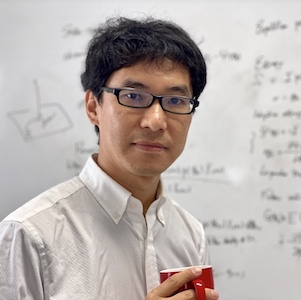 </td>
    <td>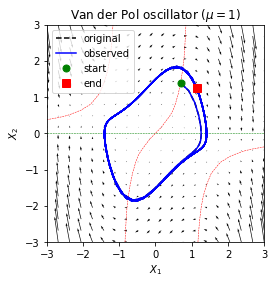</td>
  </tr>
</table>
    

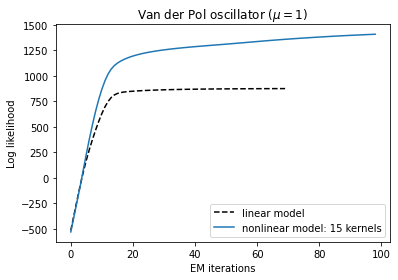

### Linear model
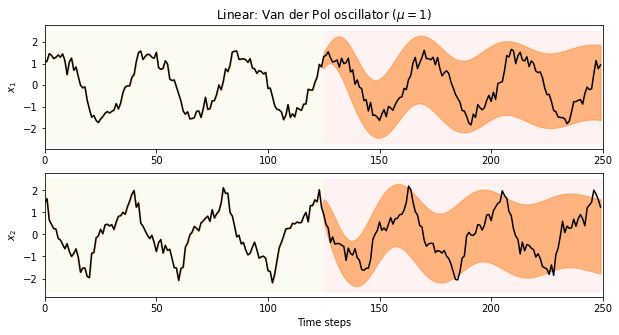
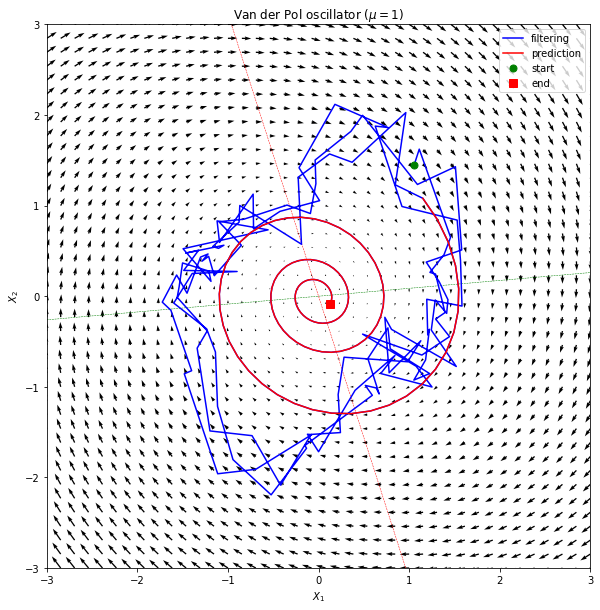

### RBF state model
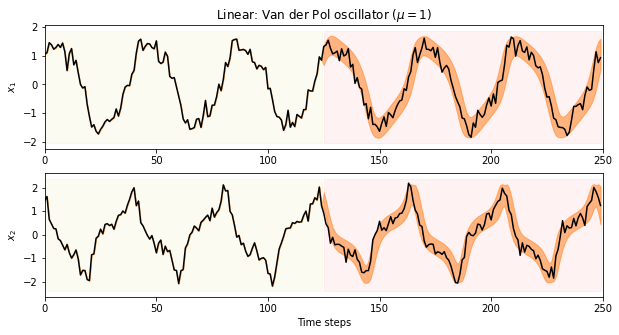 
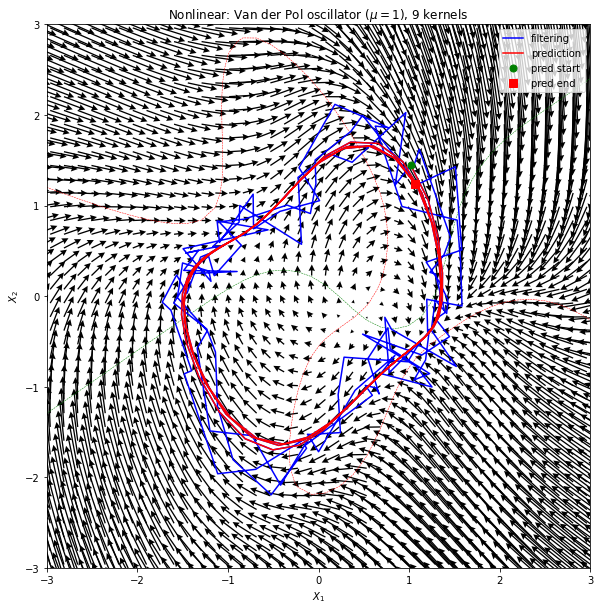

## Side note: Computational performance

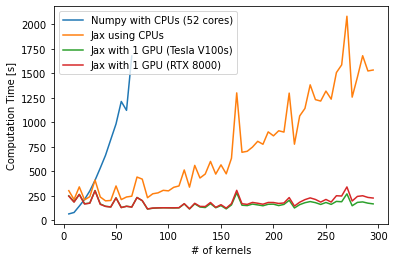

# A heteroscedastic observation model

(work with Natasha \& Guillaume)

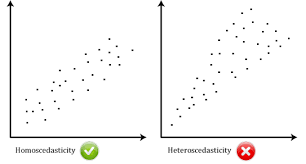

$$
p(\bY\vert\bX) = \frac{1}{Z(\bX)}\exp\left(-\frac{1}{2}(\bY-\bmu(\bX))^\top\Sigma(\bX)^{-1} (\bY-\bmu(\bX)) \right)
$$

__(Scaled) hyberbolic cosine covariance__:
$$
\bmu(\bX) = M\bX+b,
$$
$$
\Sigma(\bX) = \sigma^2\mathbf{I} + UD(\bX)U^\top = \sigma^2\mathbf{I} + \sum_{i=1}^{d_u}\mathbf{u}_iD_i(\bX)\mathbf{u}_i^\top,
$$

with $D(\bX)={\rm diag}\left({\rm cosh}(\bX)\right)$ and $U^\top U=\mathbf{I}$.

_Reminder_: $\cosh(x)=\frac{e^{-x}+e^{x}}{2}$

In [ ]:
from gaussian_toolbox.gaussian_algebra import approximate_conditionals
approximate_conditionals.HCCovGaussianConditional?

Let's use it as observation model!

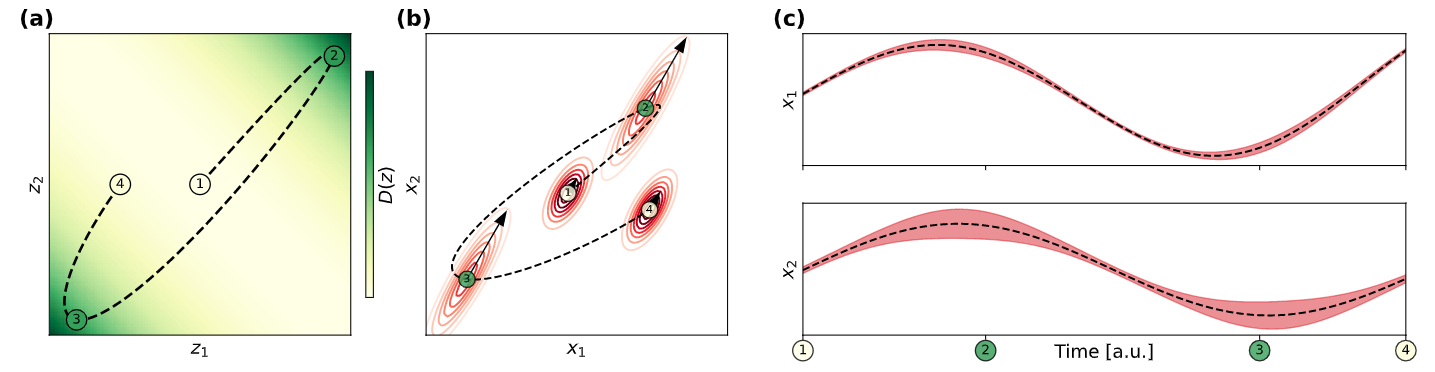

__Important feature__: Models also varying covariations!

In [ ]:
Dz = 2
Dx = X.shape[1]
Du = 1

om = observation_models.HCCovObservationModel(Dx=Dx, Dz=Dz, Du=Du, noise_x=.001)
om.W = 2 * objax.random.normal(om.W.shape)
om.beta =  .01 * objax.random.normal(om.beta.shape) ** 2
om.update_emission_density()
sm = state_models.LinearStateModel(Dz=Dz, noise_z=.1)

ssm = ssm_em.StateSpaceEM(X, om, sm)

In [ ]:
ssm.forward_path()
p_x = ssm.compute_data_density()
mean_estimate = p_x.mu
std_estimate = 2 * jnp.sqrt(p_x.Sigma.diagonal(axis1=1, axis2=2))

plt.figure(figsize=(8,8))
ax1 = plt.subplot(211)
plt.plot(X[:,0], 'k.')
plt.fill_between(range(1,T), mean_estimate[1:,0] - std_estimate[1:,0], mean_estimate[1:,0] + std_estimate[1:,0], alpha=.5)
plt.xlim([0,500])
plt.ylim([-3,3])
plt.ylabel('$x_1$')
plt.subplot(212, sharex=ax1)
plt.plot(X[:,1], 'k.')
plt.fill_between(range(1,T), mean_estimate[1:,1] - std_estimate[1:,1], mean_estimate[1:,1] + std_estimate[1:,1], 
                    alpha=.5)
plt.xlabel('Time steps')
plt.ylabel('$x_2$')
plt.ylim([-3,3])
plt.show()

# Learning the parameters

Let's check the Q-function:
$$
    Q(\theta,\theta^{\rm old}) = \sum_{t=1}^T\underline{\EE_{p(z_t\vert x_{1:T}, \theta^{\rm old})}\left[\ln \color{blue}{p(x_t\vert z_{t},\theta)}\right]} + \sum_{t=1}^T\EE_{p(z_{t-1:t}\vert x_{1:T}, \theta^{\rm old})}\left[\ln \color{red}{p(z_t\vert z_{t-1}, \theta)}\right] + \EE_{p(z_0\vert x_{1:T}, \theta^{\rm old})}\left[\ln p(z_0\vert \theta)\right].
$$

Observation model part:
$$
\EE_{p(z_t\vert x_{1:T}, \theta^{\rm old})}\left[\ln \color{blue}{p(x_t\vert z_{t}, \theta)}\right] = \EE_{p(z_{t}\vert x_{1:T}, \theta^{\rm old})}\left[-\frac{1}{2}\left(x_{t} - \bmu_{\rm lin}(z_{t})\right)^\top \underline{(Q_z(z_t))^{-1}}\left( z_{t} - \bmu_{\rm lin}(z_{t-1})\right) - \frac{1}{2}\ln\underline{\vert Q_z(z_t)}\vert \right] + {\rm const.}
$$

### Problematic terms
Matrix determinant lemma:
$$
\ln \vert Q_{\rm x}(z)\vert = (d_x-d_u)\ln \sigma^2 + \sum_{i=1}^{d_u} \ln (\sigma^2 + D_i(z)) \geq (d_x-d_u)\ln \sigma^2 + \sum_{i=1}^{d_u} [\text{$2^{nd}$ order polynomial in $z$}]
$$
Woodbury matrix inversion:
$$
(Q_x(z))^{-1} = \sigma^{-2}\mathbf{I}_{d_x} - \sigma^{-2}\sum_{i=1}^{d_u}\mathbf{u}_i \frac{D_i(z)}{\sigma^2 + D_i(z)} \mathbf{u}_i^\top \geq \sigma^{-2}\mathbf{I}_{d_x} - \sigma^{-2}\sum_{i=1}^{d_u}\mathbf{u}_i D_i(z)e^{-[\text{$2^{nd}$ order polynomial in $z$}]}\mathbf{u}_i^\top
$$

Note, that our ```integrate()``` function again becomes handy!

Hence, we can evaluate the (lower bounded) Q-function (and its gradients) &rarr; we can learn the model.

# Results: Synthetic dataset

![image.png](../figs/aistats22/synthetic.png)

# Results: Real world dataset

![image.png](../figs/aistats22/energy.png)

# Summary and outlook

Gaussian toolbox allows for
+ easy manipulation of Gaussians
+ Integration with respect to Gaussians
+ Easy intergration of NNs into the Gaussian framework

This features can be used for inference in standard probabilistic models like
+ Regression or Kalman Filter (and Smoother)

Using approximate affine transformation allows approximate inference of complex time-series models.
+ Modular framework that is easy to extend with new models.

### Potential extensions & applications

+ DAS Student currently implementing _Gaussian processes_.
+ Look into generative models: $p(\by|\bx)$ is always invertable given a $p(\bx)$ indenpendent of what the dimensions of $\bx$ and $\by$ are.
+ Extend to mixtures to cope with multimodal data.
+ Look into _expectation propagation_ and _belief propagation_.
+ Currently applying models to data from the _SenseDynamics_ project for predicting forces acting on a drone.

# Thanks a lot for your patience!

<img src="images/gauss.jpeg" width="600" height="100">

# Let's have lunch?